Mathieu Chevalley, Paul-Louis Delacour, Tristan Meynier, Daniel Garellick

In [1]:
import numpy as np 
import pandas as pd
import json
import os
from tqdm import tqdm

File Extraction from Kaggle dataset

In [2]:
articles = {}

for dirpath, subdirs, files in os.walk('/kaggle/input'):
    for x in files:
        if x.endswith(".json"):
            articles[x] = os.path.join(dirpath, x)        
metadata = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')

In [3]:
literature = []
for index, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    sha = str(row['sha'])
    if sha != 'nan':
        sha = sha + '.json';
        try:
            with open(articles[sha]) as f:
                data = json.load(f)
                key = 'abstract'
                abstract = ""
                if key in data:
                    for content in data[key]:
                        abstract += content['text']
                text = ""
                if "body_text" in data:
                    for content in data["body_text"]:
                        text += content['text']
                literature.append({'file': articles[sha], 'abstract': abstract, 'content': text}) 
        
        except KeyError:
            pass
        

100%|██████████| 51078/51078 [01:22<00:00, 618.01it/s] 


# LDA and Visualisation using t-SNE

In [4]:
text_input = []
for article in tqdm(literature):
    vec = article["abstract"]
    text_input.append(vec)

print(len(text_input))

100%|██████████| 36023/36023 [00:00<00:00, 990919.31it/s]

36023


Remove Duplicates - reduces articles from 36009 to 26249 unique abstracts 

In [5]:
text_input=list(dict.fromkeys(text_input))
print(len(text_input))

26249


Using the NLTK library the abstracts are preporcessed. In the end the tokens resulting from the preprocessing (removed stopwords, lower case, lemmatisation, stemming etc.) are put back together to form a new abstract.

In [6]:
import nltk
from nltk import word_tokenize, RegexpTokenizer,PunktSentenceTokenizer, sent_tokenize
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['elsevier','et al','bioarxiv','biorxiv', 'doi', 'author','medrxiv','pubmed','abstract', 'publisher','preprint']
stop_words.extend(newStopWords)
def prepro(texts):
    Interest=[]
    for text in texts:
        raw = text

        #Make everything lower case
        raw = raw.lower()
        #print(raw)

        # split into sentences. important not to get whitespace
        sentences = sent_tokenize(raw)
        #print('Tokenised sentences',sentences)

        # remove punctuation - this can create problems with '-' words
        import string
        table = str.maketrans('','', string.punctuation)
        nopunk=[w.translate(table) for w in sentences]
        #print('Removed Punctuation',nopunk)

        #Tokenise words
        tokens=[]
        for sentence in nopunk:
            tokens.append(nltk.word_tokenize(sentence))
        #print('Tokenised sentences',tokens)

        #Remove Stop Words. Remember add stopwords that may be relevant
        int_words=[]
        for j in range(0,len(tokens)):
            int_words.append([ i for i in tokens[j] if not i in stop_words])
        #print ('Removed stop words',words)
        
        #Remove Words less than 3 letters long
        words=[]
        for i in range(len(int_words)):
            words.append([word for word in int_words[i] if (3<=len(word))])

        # CONSIDER COMMENTING: stemming of words
        from nltk.stem.porter import PorterStemmer
        porter = PorterStemmer()
        stemmed = []
        for j in range(0,len(words)):
            stemmed.append([porter.stem(word) for word in words[j]])
        #print('Post stemming',stemmed)

        #CAN COMMENT BUT LESS CRITICAL: Lemmatisation (NOT of stemmed but could change to combine both)
        from nltk.stem import WordNetLemmatizer
        lemmatizer=WordNetLemmatizer()
        lemmed = []
        for j in range(0,len(words)):
            lemmed.append([lemmatizer.lemmatize(word) for word in words[j]])
        #print('Post Lemmatisation',lemmed)
        
        Sentence = []
        for i in range(len(lemmed)):
            b=(' '.join(word for word in lemmed[i]))
            Sentence.append(b)
        
        abstract = ' '.join(Sentence)

        Interest.append(abstract)
    #print('List of Tokenised abstracts',Interest)
    return Interest


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Interest = prepro(text_input)


The TFID vectoriser creates matrices of the tokenised words giving more weight to the inverse frequency of the words i.e. their disciminatory capacity.
Bi-grams are used to give additional discriminatory power. Only the top 10000 of the words are kept.

In [47]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=10000)
X = vectorizer.fit_transform(Interest)
tfidf_feature_names = vectorizer.get_feature_names()


t-SNE visualisation. This gives a very rough indication of the number of clusters which may exist and by extension the number of components for the LDA.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


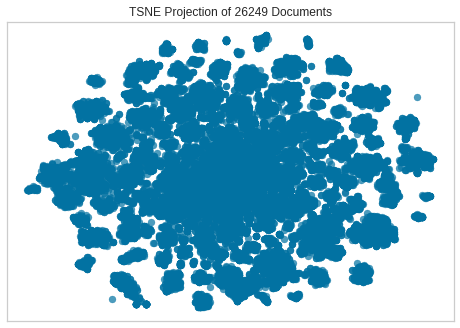

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f222e641cf8>,
               classes=None, colormap=None, colors=None, decompose=None,
               decompose_by=None, labels=None, random_state=None)

In [48]:
!pip install yellowbrick
import yellowbrick
from yellowbrick.text.tsne import tsne
tsne(X, decompose = 'svd',decompose_by=100)

LDA to determine topics of most significant clusters. We identified 16 different components to see which would fit each of the 16 questions best.

In [49]:
tf_vectorizer = CountVectorizer(ngram_range=(2, 2),max_df=0.85, min_df=2,)
tf = tf_vectorizer.fit_transform(Interest)

In [52]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 16 #Maybe this should be in a grid search of sorts.
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)



In [53]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [54]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 7
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
infectious disease public health health care respiratory syndrome infection control emerging infectious disease outbreak
Topic 1:
genome sequence fecal sample complete genome phylogenetic analysis whole genome genetic diversity sequence data
Topic 2:
respiratory virus respiratory tract respiratory infection respiratory syncytial syncytial virus tract infection viral infection
Topic 3:
full text 3cl pro clinical trial small molecule free full drug discovery climate change
Topic 4:
infectious bronchitis bronchitis virus virus ibv reserved reuse reuse allowed allowed without analysis form
Topic 5:
amino acid rna virus respiratory syndrome spike protein host cell severe acute acute respiratory
Topic 6:
acute respiratory severe acute respiratory syndrome risk factor intensive care care unit syndrome sars
Topic 7:
immune response viral infection antiviral activity innate immune gene expression immune system virus infection
Topic 8:
original source hong kong made available internatio

# Similarity Search

In [ ]:
!pip install scispacy


In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz


In [10]:
import scispacy
import spacy


In [12]:
nlp = spacy.load("en_core_sci_lg")

In [13]:
def to_vector(doc):
    return nlp(doc)

In [15]:
vectors = []
for article in tqdm(literature):
    vec = to_vector(article['abstract'])
    vectors.append(vec)


  4%|▎         | 1266/36023 [00:39<20:55, 27.68it/s]


  7%|▋         | 2610/36023 [01:19<21:54, 25.42it/s]


 10%|█         | 3756/36023 [01:58<19:09, 28.06it/s]


 14%|█▎        | 4952/36023 [02:38<24:52, 20.82it/s]


 17%|█▋        | 6089/36023 [03:19<19:42, 25.32it/s]


 20%|██        | 7214/36023 [04:01<15:01, 31.97it/s]


 23%|██▎       | 8359/36023 [04:43<18:20, 25.14it/s]


 26%|██▋       | 9457/36023 [05:24<12:40, 34.92it/s]


 29%|██▉       | 10491/36023 [06:08<23:55, 17.79it/s]


 32%|███▏      | 11632/36023 [06:50<12:53, 31.52it/s]


 36%|███▌      | 12913/36023 [07:26<09:36, 40.08it/s]


 40%|████      | 14447/36023 [08:05<08:25, 42.69it/s]


 44%|████▍     | 15823/36023 [08:43<11:38, 28.91it/s]


 48%|████▊     | 17265/36023 [09:22<05:28, 57.07it/s]


 54%|█████▍    | 19583/36023 [10:05<04:16, 64.04it/s]


 65%|██████▌   | 23565/36023 [10:53<09:09, 22.66it/s]


 69%|██████▉   | 24835/36023 [11:34<10:54, 17.09it/s]


 73%|███████▎  | 26221/36023 [12:18<04:11, 38.94it/s]


 77%|███████▋  | 27764/36023 [12:57<03:51, 35.64it/s]


 81%|████████▏ | 29322/36023 [13:35<03:54, 28.55it/s]


 86%|████████▌ | 30908/36023 [14:13<02:12, 38.71it/s]


 90%|█████████ | 32555/36023 [14:52<01:37, 35.63it/s]


 95%|█████████▍| 34141/36023 [15:30<00:43, 42.95it/s]


 99%|█████████▉| 35750/36023 [16:09<00:06, 39.32it/s]


100%|██████████| 36023/36023 [16:15<00:00, 36.94it/s]


From the abstracts the tokens which may be present in the UMLS (Unified Medical Language System) are extracted using the .ents variable. They are then merged into sentences.

In [16]:
#Extract Medical Words
MedWord=[]
for abstract in range(len(vectors)):
    MedWord.append(vectors[abstract].ents)

In [17]:
# Form Sentences from these medical words for each abstract
Sentence = []
for i in range(len(MedWord)):
    a=[]
    c=[]
    for words in range(len(MedWord[i])):
        a.append(str(MedWord[i][words]))
    b=(' '.join(word for word in a))
    sent = to_vector(b)
    c.append(sent)
    Sentence.append(c)
    

A representative question which includes multiple key words was formulated to filter the most relevant abstract. This was done by computing the similarity between the vector representations of the question and the abstracts. By selecting the 1000 most similar abstracts to this question, we then compared the full text of the respective abstracts to more precise questions as posed by the Kaggle task.

In [18]:
question = "covid 19 sars pneumonia covid-19 coronavirus medical care surge capacity and nursing homes  allocation of scarce resources personal protective equipment ppe disease management  processes of care clinical characterization and management of the virus"
vec_question = to_vector(question)

In [ ]:
similarity = []
for i in range(len(Sentence)):
    for vec in (Sentence[i]):
        if vec.has_vector:
            similarity.append(vec.similarity(vec_question))
similarity = np.array(similarity)    

In [32]:
 literature[np.argmax(similarity)]['abstract']

'As coronavirus disease 2019 (COVID-19) spreads across the world, the intensive care unit (ICU) community must prepare for the challenges associated with this pandemic. Streamlining of workflows for rapid diagnosis and isolation, clinical management, and infection prevention will matter not only to patients with COVID-19, but also to health-care workers and other patients who are at risk from nosocomial transmission. Management of acute respiratory failure and haemodynamics is key. ICU practitioners, hospital administrators, governments, and policy makers must prepare for a substantial increase in critical care bed capacity, with a focus not just on infrastructure and supplies, but also on staff management. Critical care triage to allow the rationing of scarce ICU resources might be needed. Researchers must address unanswered questions, including the role of repurposed and experimental therapies. Collaboration at the local, regional, national, and international level offers the best ch

In [21]:
import heapq

ind = heapq.nlargest(1000, range(len(similarity)), similarity.take)

In [22]:
 medical_care_articles = np.array(literature)[np.array(ind)]


In [23]:
texts= []
for article in medical_care_articles:
    vec = article["content"]
    texts.append(vec)

In [24]:
import nltk
from nltk import sent_tokenize
sentences = []
for article in tqdm(medical_care_articles):
    text = article["content"]
    sentences += sent_tokenize(text)


100%|██████████| 1000/1000 [00:07<00:00, 129.43it/s]


In [25]:
vec_sentences = []
for sentence in tqdm(sentences):
    vec_sentences.append(to_vector(sentence))


  2%|▏         | 2737/147379 [00:31<27:54, 86.35it/s]


  4%|▍         | 5563/147379 [01:02<26:59, 87.59it/s]


  6%|▌         | 8276/147379 [01:34<33:45, 68.68it/s]


  7%|▋         | 11043/147379 [02:05<26:42, 85.05it/s]


  9%|▉         | 13821/147379 [02:36<25:10, 88.40it/s]


 11%|█         | 16534/147379 [03:07<23:02, 94.68it/s]


 13%|█▎        | 19201/147379 [03:39<25:10, 84.84it/s]


 15%|█▍        | 21935/147379 [04:10<23:53, 87.50it/s]


 17%|█▋        | 24666/147379 [04:41<26:06, 78.34it/s]


 19%|█▊        | 27340/147379 [05:12<23:59, 83.42it/s]


 20%|██        | 30151/147379 [05:43<21:02, 92.88it/s]


 22%|██▏       | 32905/147379 [06:14<21:43, 87.83it/s]


 24%|██▍       | 35652/147379 [06:46<22:41, 82.07it/s]


 26%|██▌       | 38391/147379 [07:17<22:29, 80.74it/s]


 28%|██▊       | 41168/147379 [07:48<19:07, 92.53it/s]


 30%|██▉       | 43891/147379 [08:19<19:01, 90.65it/s]


 32%|███▏      | 46659/147379 [08:50<18:13, 92.09it/s]


 34%|███▎      | 49412/147379 [09:21<18:16, 89.33it/s]


 35%|███▌      | 52207/147379 [09:52<17:33, 90.32it/s]


 37%|███▋      | 54967/147379 [10:23<17:55, 85.91it/s]


 39%|███▉      | 57738/147379 [10:54<16:31, 90.43it/s]


 41%|████      | 60446/147379 [11:25<16:00, 90.54it/s]


 43%|████▎     | 63244/147379 [11:56<15:27, 90.67it/s]


 45%|████▍     | 66095/147379 [12:27<15:23, 87.99it/s]


 47%|████▋     | 68904/147379 [12:58<15:48, 82.75it/s]


 49%|████▊     | 71634/147379 [13:29<12:48, 98.57it/s] 


 50%|█████     | 74375/147379 [14:00<14:17, 85.12it/s]


 52%|█████▏    | 77033/147379 [14:31<11:36, 101.07it/s]


 54%|█████▍    | 79721/147379 [15:02<11:42, 96.35it/s]


 56%|█████▌    | 82435/147379 [15:33<12:39, 85.53it/s]


 58%|█████▊    | 85088/147379 [16:05<14:26, 71.90it/s]


 60%|█████▉    | 87770/147379 [16:36<11:10, 88.90it/s]


 61%|██████▏   | 90530/147379 [17:07<12:20, 76.76it/s]


 63%|██████▎   | 93321/147379 [17:38<10:40, 84.41it/s]


 65%|██████▌   | 96070/147379 [18:09<08:50, 96.68it/s]


 67%|██████▋   | 98784/147379 [18:40<09:44, 83.17it/s]


 69%|██████▉   | 101457/147379 [19:10<08:10, 93.59it/s]


 71%|███████   | 104092/147379 [19:41<07:52, 91.71it/s]


 72%|███████▏  | 106789/147379 [20:11<07:55, 85.34it/s]


 74%|███████▍  | 109454/147379 [20:42<06:20, 99.54it/s] 


 76%|███████▌  | 112108/147379 [21:12<06:44, 87.11it/s]


 78%|███████▊  | 114796/147379 [21:43<05:58, 90.83it/s]


 80%|███████▉  | 117584/147379 [22:13<05:09, 96.20it/s]


 82%|████████▏ | 120260/147379 [22:44<04:54, 92.07it/s]


 83%|████████▎ | 122799/147379 [23:14<04:21, 93.87it/s]


 85%|████████▌ | 125507/147379 [23:45<03:25, 106.42it/s]


 87%|████████▋ | 128244/147379 [24:15<03:45, 84.89it/s]


 89%|████████▉ | 130890/147379 [24:45<03:08, 87.69it/s]


 91%|█████████ | 133539/147379 [25:16<02:36, 88.56it/s]


 92%|█████████▏| 136244/147379 [25:46<01:50, 100.97it/s]


 94%|█████████▍| 138909/147379 [26:17<01:38, 86.11it/s]


 96%|█████████▌| 141525/147379 [26:47<01:07, 86.37it/s]


 98%|█████████▊| 144143/147379 [27:17<00:40, 80.08it/s]


100%|█████████▉| 146740/147379 [27:48<00:07, 89.85it/s]


100%|██████████| 147379/147379 [27:55<00:00, 87.95it/s]


In [ ]:
#Extract Medical Words From Sentences
medent=[]
for words in range(len(vec_sentences)):
    medent.append(vec_sentences[words].ents)

In [27]:
# Form Sentences from these medical words for each abstract
match_sentence = []
for i in range(len(medent)):
    a=[]
    c=[]
    for words in range(len(medent[i])):
        a.append(str(medent[i][words]))
    b=(' '.join(word for word in a))
    sent = to_vector(b)
    c.append(sent)
    match_sentence.append(c)
    

Insert below the medical care question that should be answered with the most relevant sentence.

In [34]:
question = "Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients"
vec_question = to_vector(question)

In [35]:
similarity_sen = []
for i in range(len(match_sentence)):
    for vec in (match_sentence[i][0]):
        if vec.has_vector:
            similarity_sen.append(vec.similarity(vec_question))
similarity_sen = np.array(similarity_sen)    

In [36]:
ind2 = heapq.nlargest(10, range(len(similarity_sen)), similarity_sen.take)

In [37]:
res = []
for i in ind2:
    res.append(vec_sentences[i])

In [39]:
res

[The challenge for many institutions, however, may be to encourage that this information be provided in a balanced and proportional manner, rather than the more common 'shock horror' approach.Lay members should be included in planning activities and in the organisation of training and simulated exercise activities.,
 Where decisions were made on either treatment limitation or withdrawal, these were in accordance with either national or locally agreed policies and were shared with appropriately experienced colleagues.6.,
 All reasonable alternative options were explored.It is therefore confirmed that the staff did the best that they could for the benefits of patients in these very difficult circumstances and consequently should be fully supported for doing all that they could to maintain services for patients most likely to benefit.,
 This effect is present with both high and low levels of infection rates (Figure 2, 3) .Next, we incorporated productivity of the workers in the period of 

### Other explored avenues

As mentioned in the WIP report for this part of the project, we attempted to create a Bag-of-Words using a UMLS linker. We identified the medical entities as above and passed them through the UMLS Linker. This however proved very cumbersome both in terms of run-time and RAM and became overall prohibitive when exploration beyond abstracts was necessary. There is a more established method for linking text passage to the UMLS with a tool called MetaMap. Its use however was complex for multiple reasons, including that it was not implemented in Python. Therefore this approach was not continued.

-**NB**- This is a follow up to the first report and for brevity the work conducted at that stage is not repeated here. As a reminder, a similar approach to the above similarity search was used. The whole abstracts were fed into vectors and directly compared to the question whithout any preprocessing. This was compared to another approach, where the abstracts were preprocessed using the pipeline defined in the LDA part of this notebook. It should be noted that running the code with only medical tokens results in a poorer performance in terms of sentence matching. This is made clear with the example choice of question in this notebook. We have added the same documents as last submission containing the results to the above questions to accentuate this difference in results.